In [1]:
# Basic Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For tesxt:
import re

# For times:
import time

# Set a random seed for imputation
#  Source:  https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html
np.random.seed(42)

# Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error

# For the recommender
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity

In [39]:
# Read in all data with the full compliment of engineered features
lstn = pd.read_csv('../data/prepped_training.csv')
validation = pd.read_csv('../data/prepped_validation.csv')
test = pd.read_csv('../data/prepped_testing.csv')

# Read in the data with original full-text formatting for the recommender
lstn_full_text = pd.read_csv('../data/listings_train.csv')
validation_full_text = pd.read_csv('../data/listings_val.csv')
testing_full_text = pd.read_csv('../data/listings_test.csv')

In [42]:
# Create an aggregated dataframe with ALL engineered features for ALL listings
all_data_full_ft = pd.concat([lstn, validation])
all_data_full_ft = pd.concat([all_data_full_ft, test])
all_data_full_ft.reset_index(drop = True)

,host_since,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,...,neighborhood_overview_you might,neighborhood_overview_you re,neighborhood_overview_you to,neighborhood_overview_you will,neighborhood_overview_you will find,neighborhood_overview_young,neighborhood_overview_young professionals,neighborhood_overview_young professionals and,neighborhood_overview_your,neighborhood_overview_zoo
0,17162.0,100.0,100.0,7,8,42.325782,-71.072262,5,2.0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,19213.0,100.0,100.0,1,1,42.333055,-71.048747,4,1.0,2.0,...,0,0,0,0,0,0,0,0,0,0
2,16272.0,100.0,0.0,31,34,42.313330,-71.093390,1,1.0,1.0,...,0,0,0,0,0,1,1,0,0,0
3,18164.0,95.0,51.0,320,1450,42.354869,-71.132336,2,4.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,17140.0,100.0,96.0,3,8,42.351970,-71.172330,16,4.0,5.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859,18164.0,95.0,51.0,320,1450,42.343407,-71.153692,2,3.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3860,16272.0,100.0,0.0,31,34,42.305360,-71.072210,1,1.0,1.0,...,0,0,0,0,0,1,1,0,0,0
3861,17151.0,100.0,97.0,4807,5358,42.351190,-71.064020,2,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3862,18164.0,95.0,51.0,320,1450,42.330100,-71.102200,1,3.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# Create an aggregate dataframe with ALL listings in the original full-text format
all_data_full_text = pd.concat([lstn_full_text, validation_full_text])
all_data_full_text = pd.concat([all_data_full_text, testing_full_text])
all_data_full_text.reset_index(drop = True)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,827621935761246987,https://www.airbnb.com/rooms/827621935761246987,20230319180919,2023-03-19,city scrape,101 Spacious 2bed 2bath wit 1parking,Your family will be close to everything when y...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,108724738,...,5.00,4.00,5.00,STR-521858,t,7,7,0,0,1.00
1,689981885807910567,https://www.airbnb.com/rooms/689981885807910567,20230319180919,2023-03-19,city scrape,Clean and convenient! Walk to Boston highlights!,You will love staying in vibrant South Boston!...,South Boston is an energetic neighborhood wher...,https://a0.muscache.com/pictures/prohost-api/H...,474224382,...,4.84,4.47,4.37,STR-485772,t,1,1,0,0,2.86
2,17779084,https://www.airbnb.com/rooms/17779084,20230319180919,2023-03-19,city scrape,Huge rm Renovated Clean Subway Safe neighborhood,(Please do not make a request right away. But ...,Peaceful and orderly neighborhood. Near the ho...,https://a0.muscache.com/pictures/41aa09b0-ffab...,18517776,...,NaN,NaN,NaN,NaN,f,31,0,31,0,NaN
3,808446005860043071,https://www.airbnb.com/rooms/808446005860043071,20230319180919,2023-03-19,city scrape,Unfurnished Queen Bedroom C in #442: Allston,"This good-looking, spacious and neat room is a...",NaN,https://a0.muscache.com/pictures/prohost-api/H...,297860058,...,NaN,NaN,NaN,NaN,t,279,5,274,0,NaN
4,49485216,https://www.airbnb.com/rooms/49485216,20230319180919,2023-03-20,city scrape,Casa Chic - Luxurious Urban Oasis,"Enjoy an immaculate, fully renovated, luxuriou...",In a charming neighborhood with wonderful rest...,https://a0.muscache.com/pictures/miso/Hosting-...,106312822,...,4.75,4.75,4.85,Exempt: This listing is a unit that has contra...,t,1,1,0,0,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859,803384764461309863,https://www.airbnb.com/rooms/803384764461309863,20230319180919,2023-03-19,city scrape,Furnished Queen Bedroom C in #420: Brighton,"This good-looking, spacious and neat room is a...",NaN,https://a0.muscache.com/pictures/prohost-api/H...,297860058,...,NaN,NaN,NaN,NaN,t,279,5,274,0,NaN
3860,13242393,https://www.airbnb.com/rooms/13242393,20230319180919,2023-03-19,city scrape,Renovated House near Subway/Rail Everything New,(Please do not make a request right away. But ...,Peaceful and orderly neighborhood. Near the ho...,https://a0.muscache.com/pictures/32c42677-41c3...,18517776,...,5.00,4.33,5.00,NaN,f,31,0,31,0,0.04
3861,53428804,https://www.airbnb.com/rooms/53428804,20230319180919,2023-03-20,city scrape,Downtown 1BR w/ Luxury Amenities & Rooftop Views,Feel at home wherever you choose to live with ...,This furnished apartment is located in Boston’...,https://a0.muscache.com/pictures/prohost-api/H...,107434423,...,NaN,NaN,NaN,NaN,f,340,340,0,0,NaN
3862,815888536731149952,https://www.airbnb.com/rooms/815888536731149952,20230319180919,2023-03-19,city scrape,Furnished Full Bedroom A in #428: Mission Hill,"This good-looking, spacious and neat room is a...",NaN,https://a0.muscache.com/pictures/prohost-api/H...,297860058,...,NaN,NaN,NaN,NaN,t,279,5,274,0,NaN


In [45]:
# Check that all listings in both datasets are matching, by using the listing latitudes
# which are already formatted as numbers in both and will be unique for each listing
# The code below will out a number euqal the number of rows above if done correctly
sum(all_data_full_ft['latitude'] == all_data_full_text['latitude'])

3864

In [21]:
# Need to import the original (training) dataset with no formatting to pull from at the very end
recommender_population = pd.read_csv('../data/listings_train.csv')

# Create Datasets for Recommender

In [20]:
recommender_population

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,827621935761246987,https://www.airbnb.com/rooms/827621935761246987,20230319180919,2023-03-19,city scrape,101 Spacious 2bed 2bath wit 1parking,Your family will be close to everything when y...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,108724738,...,5.00,4.00,5.00,STR-521858,t,7,7,0,0,1.00
1,689981885807910567,https://www.airbnb.com/rooms/689981885807910567,20230319180919,2023-03-19,city scrape,Clean and convenient! Walk to Boston highlights!,You will love staying in vibrant South Boston!...,South Boston is an energetic neighborhood wher...,https://a0.muscache.com/pictures/prohost-api/H...,474224382,...,4.84,4.47,4.37,STR-485772,t,1,1,0,0,2.86
2,17779084,https://www.airbnb.com/rooms/17779084,20230319180919,2023-03-19,city scrape,Huge rm Renovated Clean Subway Safe neighborhood,(Please do not make a request right away. But ...,Peaceful and orderly neighborhood. Near the ho...,https://a0.muscache.com/pictures/41aa09b0-ffab...,18517776,...,NaN,NaN,NaN,NaN,f,31,0,31,0,NaN
3,808446005860043071,https://www.airbnb.com/rooms/808446005860043071,20230319180919,2023-03-19,city scrape,Unfurnished Queen Bedroom C in #442: Allston,"This good-looking, spacious and neat room is a...",NaN,https://a0.muscache.com/pictures/prohost-api/H...,297860058,...,NaN,NaN,NaN,NaN,t,279,5,274,0,NaN
4,49485216,https://www.airbnb.com/rooms/49485216,20230319180919,2023-03-20,city scrape,Casa Chic - Luxurious Urban Oasis,"Enjoy an immaculate, fully renovated, luxuriou...",In a charming neighborhood with wonderful rest...,https://a0.muscache.com/pictures/miso/Hosting-...,106312822,...,4.75,4.75,4.85,Exempt: This listing is a unit that has contra...,t,1,1,0,0,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2776,29366852,https://www.airbnb.com/rooms/29366852,20230319180919,2023-03-19,city scrape,Upper Duplex Penthouse with Water View,Family friendly spacious 4 bedroom/2 bathroom ...,NaN,https://a0.muscache.com/pictures/d8ea05c6-a278...,20259404,...,4.53,4.72,4.50,STR-393234,t,1,1,0,0,2.13
2777,48883519,https://www.airbnb.com/rooms/48883519,20230319180919,2023-03-20,city scrape,"Simple 1BR w/ 99 WalkScore, Fast Wifi + SmartLock",This 1br apartment with laundry in building is...,"Walking distance from the Boston Common, Finan...",https://a0.muscache.com/pictures/154731d1-b4d7...,275849638,...,4.90,4.73,4.53,STR-461740,f,50,50,0,0,4.78
2778,37709576,https://www.airbnb.com/rooms/37709576,20230319180919,2023-03-19,city scrape,"North End- Newly Renovated, Prof. Clean, 1bd Apt",Right in the heart of Boston's Historic North ...,"The North End, Boston’s “Little Italy,’’ is fa...",https://a0.muscache.com/pictures/3353a3e7-781f...,697401,...,5.00,4.92,4.58,NaN,f,3,3,0,0,0.30
2779,43097089,https://www.airbnb.com/rooms/43097089,20230319180919,2023-03-20,previous scrape,Newer Loft-like basement unit at Red line train,My most popular unit! Comfortable and open lo...,The neighborhood is mixed with retired and wor...,https://a0.muscache.com/pictures/87329d4b-1626...,10778805,...,NaN,NaN,NaN,NaN,f,4,2,2,0,NaN


---
---
# Quick Recommender Test

In [4]:
# Need to create a sparse matrix from the dataframe
lstn_sparse = sparse.csr_matrix(lstn.drop(columns = ['price', 'log_price']))

In [5]:
lstn_similarities = cosine_similarity(lstn_sparse)

In [6]:
lstn_similarities

array([[1.        , 0.9999799 , 0.99898464, ..., 0.99995238, 0.99992754,
        0.99831269],
       [0.9999799 , 1.        , 0.9989273 , ..., 0.99995941, 0.99992367,
        0.99823207],
       [0.99898464, 0.9989273 , 1.        , ..., 0.99856622, 0.99858148,
        0.99969097],
       ...,
       [0.99995238, 0.99995941, 0.99856622, ..., 1.        , 0.99996121,
        0.99780594],
       [0.99992754, 0.99992367, 0.99858148, ..., 0.99996121, 1.        ,
        0.99772996],
       [0.99831269, 0.99823207, 0.99969097, ..., 0.99780594, 0.99772996,
        1.        ]])

In [7]:
rec = pd.DataFrame(lstn_similarities, index=lstn.index, columns=lstn.index)
rec

,0,1,2,3,4,5,6,7,8,9,...,2771,2772,2773,2774,2775,2776,2777,2778,2779,2780
0,1.000000,0.999980,0.998985,0.996476,0.998994,0.998978,0.998831,0.998772,0.998670,0.999749,...,0.999118,0.999775,0.999765,0.996368,0.999731,0.998832,0.999021,0.999952,0.999928,0.998313
1,0.999980,1.000000,0.998927,0.996427,0.998871,0.998849,0.998755,0.998693,0.998579,0.999787,...,0.999045,0.999806,0.999824,0.996361,0.999782,0.998732,0.998973,0.999959,0.999924,0.998232
2,0.998985,0.998927,1.000000,0.995735,0.999647,0.999683,0.999869,0.999868,0.999743,0.997987,...,0.999768,0.997896,0.997947,0.995831,0.997883,0.999746,0.999903,0.998566,0.998581,0.999691
3,0.996476,0.996427,0.995735,1.000000,0.995385,0.995357,0.995272,0.995198,0.995082,0.996192,...,0.995520,0.996248,0.996230,0.999933,0.996189,0.995218,0.995809,0.996465,0.996449,0.996556
4,0.998994,0.998871,0.999647,0.995385,1.000000,0.999978,0.999889,0.999835,0.999881,0.997990,...,0.999927,0.997857,0.997840,0.995218,0.997849,0.999949,0.999760,0.998581,0.998458,0.999495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2776,0.998832,0.998732,0.999746,0.995218,0.999949,0.999927,0.999944,0.999948,0.999983,0.997836,...,0.999970,0.997619,0.997623,0.995133,0.997677,1.000000,0.999874,0.998381,0.998269,0.999617
2777,0.999021,0.998973,0.999903,0.995809,0.999760,0.999737,0.999911,0.999938,0.999886,0.998114,...,0.999902,0.997937,0.997974,0.995869,0.997988,0.999874,1.000000,0.998604,0.998546,0.999758
2778,0.999952,0.999959,0.998566,0.996465,0.998581,0.998566,0.998376,0.998297,0.998194,0.999873,...,0.998731,0.999915,0.999910,0.996340,0.999880,0.998381,0.998604,1.000000,0.999961,0.997806
2779,0.999928,0.999924,0.998581,0.996449,0.998458,0.998459,0.998284,0.998239,0.998086,0.999845,...,0.998625,0.999905,0.999892,0.996350,0.999849,0.998269,0.998546,0.999961,1.000000,0.997730


# Recommender Data Entry

In [8]:
'''
The purpose of this function is to allow one of the follwoing cells to
be used like a web page where a user would enter data for their desired
Airbnb listing.  Specifically, this function will allow for the empty 
lists next to each of the variables in the cell to operate as text entry 
fields which can be empty if the user chooses to omit that data.

Setting a variable but not equating it to anything will result in errors.

By running this function when a value is entered into on of the empty
text-entry lists, a value is then populated into a list corresponding to
the name of the column corresponding to that variable in the training data.
When nothing, is entered into a text entry list, this function will return 
nothing so that the list corresponding to the training data column will 
remain empty and can be easily dropped with a single dropna function.
'''

def listing_ft_returner(entry_list):
    if len(entry_list) == 1:
        return entry_list[0]
    elif len(entry_list) > 1:
        # Srouce to help with raising an error:
        #  https://rollbar.com/blog/throwing-exceptions-in-python/
        raise Exception('ONLY ONE ENTRY PLEASE!')
    else:
        return

In [9]:
# *********************  USER DESIRED AIRBNB LISTING FORM  *********************

# How many peopl ein your party ?
accommodates = [4] # (enter a number)

# How many separate bedrooms would you like?
bedrooms = [] # (enter a number)

# How many beds do you need?
beds = [] # (enter a number)

# What's the minimum number of nights you would plan to stay?
minimum_nightsroom_type_hotel_room = [] # (enter a number)

# Selected room type if desired
room_type_entire_home_apt = [] # enter 1 to select *
room_type_private_room = [] # enter 1 to select
room_type_shared_room = [] # enter 1 to select

# Available now?
has_availability_t = [] # enter 1 to select

# Select your neighborhood if desired
'''
Please select only 1 for best results
'''
allston = [] # enter 1 to select *
back_bay = [] # enter 1 to select
bay_village = [] # enter 1 to select
beacon_hill = [] # enter 1 to select
brighton = [] # enter 1 to select
charlestown = [] # enter 1 to select
chinatown = [] # enter 1 to select
dorchester = [] # enter 1 to select
downtown = [] # enter 1 to select
east_boston = [1] # enter 1 to select
fenway = [] # enter 1 to select
hyde_park = [] # enter 1 to select
jamaica_plain = [] # enter 1 to select
leather_district = [] # enter 1 to select
longwood_medical_area = [] # enter 1 to select
mattapan = [] # enter 1 to select
mission_hill = [] # enter 1 to select
north_end = [] # enter 1 to select
roslindale = [] # enter 1 to select
roxbury = [] # enter 1 to select
south_boston = [] # enter 1 to select
south_boston_waterfront = [] # enter 1 to select
south_end = [] # enter 1 to select
west_end = [] # enter 1 to select
west_roxbury = [] # enter 1 to select


# Select amenties if desired
wifi = [1] # enter 1 to select
kitchen = [] # enter 1 to select
essentials = [] # enter 1 to select
dedicated_workspace = [] # enter 1 to select
pets_allowed = [] # enter 1 to select
gym = [] # enter 1 to select
indoor_fireplace = [] # enter 1 to select
indoor_fireplace_electric = [] # enter 1 to select
fire_pit = [] # enter 1 to select
waterfront = [] # enter 1 to select
free_street_parking = [] # enter 1 to select
free_parking_on_premises = [] # enter 1 to select
patio_or_balcony = [] # enter 1 to select
backyard = [] # enter 1 to select
bbq_grill = [] # enter 1 to select
private_patio_or_balcony = [] # enter 1 to select
outdoor_dining_area = [] # enter 1 to select
pack_n_play_travel_crib = [] # enter 1 to select
childrens_books_and_toys = [] # enter 1 to select
board_games = [] # enter 1 to select
window_guards = [] # enter 1 to select
high_chair = [] # enter 1 to select

# * Note:  These variables were removed during one hot encode ing go nowhere...
#   In a future revision of this program, code must be added to specifically select these features
#    as merely selecting them does not actually zero-out the other columns

In [10]:
# This is where all the collumns are to to their vairables inside the functions

# Create the empty dataframe that will bepredicted upon
rec_data = pd.DataFrame(columns=lstn.columns)

# Create all the columns data
rec_data["accommodates"] = [listing_ft_returner(accommodates)]
rec_data["bedrooms"] = [listing_ft_returner(bedrooms)]
rec_data["beds"] = [listing_ft_returner(beds)]
rec_data["minimum_nightsroom_type_Hotel room"] = [listing_ft_returner(minimum_nightsroom_type_hotel_room)]
rec_data["room_type_Private room"] = [listing_ft_returner(room_type_private_room)]
rec_data["room_type_Shared room"] = [listing_ft_returner(room_type_shared_room)]
rec_data["has_availability_t"] = [listing_ft_returner(has_availability_t)]
rec_data["neighbourhood_cleansed_Back Bay"] = [listing_ft_returner(back_bay)]
rec_data["neighbourhood_cleansed_Bay Village"] = [listing_ft_returner(bay_village)]
rec_data["neighbourhood_cleansed_Beacon Hill"] = [listing_ft_returner(beacon_hill)]
rec_data["neighbourhood_cleansed_Brighton"] = [listing_ft_returner(brighton)]
rec_data["neighbourhood_cleansed_Charlestown"] = [listing_ft_returner(charlestown)]
rec_data["neighbourhood_cleansed_Chinatown"] = [listing_ft_returner(chinatown)]
rec_data["neighbourhood_cleansed_Dorchester"] = [listing_ft_returner(dorchester)]
rec_data["neighbourhood_cleansed_Downtown"] = [listing_ft_returner(downtown)]
rec_data["neighbourhood_cleansed_East Boston"] = [listing_ft_returner(east_boston)]
rec_data["neighbourhood_cleansed_Fenway"] = [listing_ft_returner(fenway)]
rec_data["neighbourhood_cleansed_Hyde Park"] = [listing_ft_returner(hyde_park)]
rec_data["neighbourhood_cleansed_Jamaica Plain"] = [listing_ft_returner(jamaica_plain)]
rec_data["neighbourhood_cleansed_Leather District"] = [listing_ft_returner(leather_district)]
rec_data["neighbourhood_cleansed_Longwood Medical Area"] = [listing_ft_returner(longwood_medical_area)]
rec_data["neighbourhood_cleansed_Mattapan"] = [listing_ft_returner(mattapan)]
rec_data["neighbourhood_cleansed_Mission Hill"] = [listing_ft_returner(mission_hill)]
rec_data["neighbourhood_cleansed_North End"] = [listing_ft_returner(north_end)]
rec_data["neighbourhood_cleansed_Roslindale"] = [listing_ft_returner(roslindale)]
rec_data["neighbourhood_cleansed_Roxbury"] = [listing_ft_returner(roxbury)]
rec_data["neighbourhood_cleansed_South Boston"] = [listing_ft_returner(south_boston)]
rec_data["neighbourhood_cleansed_South Boston Waterfront"] = [listing_ft_returner(south_boston_waterfront)]
rec_data["neighbourhood_cleansed_South End"] = [listing_ft_returner(south_end)]
rec_data["neighbourhood_cleansed_West End"] = [listing_ft_returner(west_end)]
rec_data["neighbourhood_cleansed_West Roxbury"] = [listing_ft_returner(west_roxbury)]
rec_data["amen_Wifi"] = [listing_ft_returner(wifi)]
rec_data["amen_Kitchen"] = [listing_ft_returner(kitchen)]
rec_data["amen_Essentials"] = [listing_ft_returner(essentials)]
rec_data["amen_Dedicated workspace"] = [listing_ft_returner(dedicated_workspace)]
rec_data["amen_Pets allowed"] = [listing_ft_returner(pets_allowed)]
rec_data["amen_Gym"] = [listing_ft_returner(gym)]
rec_data["amen_Indoor fireplace"] = [listing_ft_returner(indoor_fireplace)]
rec_data["amen_Indoor fireplace: electric"] = [listing_ft_returner(indoor_fireplace_electric)]
rec_data["amen_Fire pit"] = [listing_ft_returner(fire_pit)]
rec_data["amen_Waterfront"] = [listing_ft_returner(waterfront)]
rec_data["amen_Free street parking"] = [listing_ft_returner(free_street_parking)]
rec_data["amen_Free parking on premises"] = [listing_ft_returner(free_parking_on_premises)]
rec_data["amen_Patio or balcony"] = [listing_ft_returner(patio_or_balcony)]
rec_data["amen_Backyard"] = [listing_ft_returner(backyard)]
rec_data["amen_BBQ grill"] = [listing_ft_returner(bbq_grill)]
rec_data["amen_Private patio or balcony"] = [listing_ft_returner(private_patio_or_balcony)]
rec_data["amen_Outdoor dining area"] = [listing_ft_returner(outdoor_dining_area)]
rec_data["amen_Pack \\u2019n play/Travel crib"] = [listing_ft_returner(pack_n_play_travel_crib)]
rec_data["amen_Children\\u2019s books and toys"] = [listing_ft_returner(childrens_books_and_toys)]
rec_data["amen_Board games"] = [listing_ft_returner(board_games)]
rec_data["amen_Window guards"] = [listing_ft_returner(window_guards)]
rec_data["amen_High chair"] = [listing_ft_returner(high_chair)]

rec_data.dropna(axis=1, inplace=True)
rec_data

,accommodates,neighbourhood_cleansed_East Boston,amen_Wifi
0,4,1,1


# Predict Listing Price Based on User Inputs

In [11]:
'''
Create a function that will create training and validation datasets based on a list of
input columns against price and log_price data.  Do this only for the X data, y will 
always be the same.
'''

def listing_predictor(data_train, data_to_predict, model):
    
    # X Data    
    X_train_df  = data_train[data_to_predict.columns]
    X_val_df = data_to_predict
    
    # y dataset:    
    y_train = data_train['price']

    # **************  PRICE MODEL  ****************************************
    # Run Models on price
    model_instance = model
    model_instance.fit(X_train_df, y_train)

    # Predict      
    preds_price_val = model_instance.predict(X_val_df)
    
    return round(preds_price_val[0], 2)

In [12]:
rec_predict = listing_predictor(lstn[lstn.price < 1000], rec_data, RandomForestRegressor(random_state=42))
rec_predict

156.94

# Find Similar Listings with Cosine Similarity

In [35]:
cust_facing_columns = [
 'listing_url',
 'name',
 'description',
 'neighborhood_overview',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'minimum_nights',
 'has_availability',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'instant_bookable']

In [13]:
# Make a list of cosine similarities

sim_dict = {
    'listing_index': [],
    'similarity': [],
    'price': []
}

# Create a variable for the number of recommendations
num_recs = 30

'''
PLAN:
* make this a dictionary of the three values
* convert that dictionary to a dataframe
* Sort the dataframe by similarity, take the top 30
* find the minimum similarity value
* then find all listings with that similarity value
* of those, find the x number cheaper to complete the list of 30 cheapest units

'''

for index in lstn[lstn.price <300].index:
    
    # Calculate the similarity of the desired listing against each listing
    sim = cosine_similarity([(rec_data.iloc[0]), (lstn[rec_data.columns].iloc[index])])[0][1]
    
    # Append the listing index, similarity, and price to the dictionary
    sim_dict['listing_index'].append(index)
    sim_dict['similarity'].append(sim)
    sim_dict['price'].append(lstn['price'][index])

# Sort the listings by similarity score (descending) and then price (ascending)
# Soureces for help with this:
# * https://sparkbyexamples.com/pandas/pandas-sort-dataframe-by-multiple-columns/#:~:text=You%20can%20sort%20pandas%20DataFrame,descending%20and%20True%20for%20ascending.
# * https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html
sim_df = pd.DataFrame(sim_dict).sort_values(by=['similarity', 'price'], ascending=[False, True])

In [16]:
sim_df.head(30)

,listing_index,similarity,price
210,240,1.00000,83.0
1367,1573,1.00000,90.0
850,980,1.00000,92.0
1902,2186,1.00000,99.0
1842,2120,1.00000,100.0
410,465,1.00000,110.0
1498,1723,1.00000,110.0
300,346,1.00000,113.0
2308,2660,1.00000,133.0
774,882,1.00000,140.0


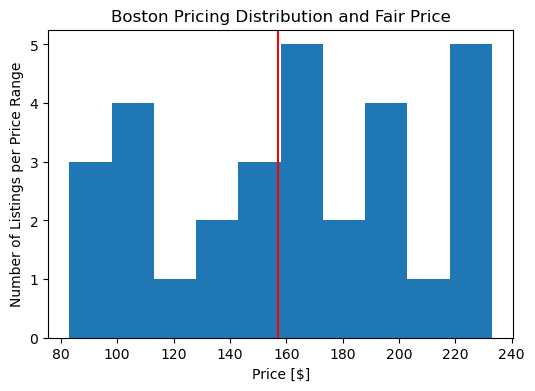

In [32]:
'''
The minimum and maximum similarities must be determined in order to report a logical amount of
of listings.  For example:  If the top n-number of suggestions are all the same similarity, then
technically, all others should be reported with the same similarity score - or at least the prices
for the identical similarity scores.

If the similarity scores are not the same, then simply report the top n-number of listings's prices.
'''
max_sim = sim_df['similarity'][0:num_recs].max()
min_sim = sim_df['similarity'][0:num_recs].min()

if max_sim == min_sim:
    # find all indexzes with that similarity
    suggested_indexes = sim_df[sim_df['similarity'] == min_sim]['listing_index']
    
    # Find all the prices for those indexes suggested above
    suggested_prices = sim_df[sim_df['similarity'] == min_sim]['price']
    
else:
    # Just give the top num_recs similarity differences
    suggested_indexes = sim_df[0:num_recs]['listing_index']
    
    # Find all the prices for those indexes suggested above
    suggested_prices = sim_df[0:num_recs]['price']

plt.figure(figsize = (6, 4))
plt.title('Boston Pricing Distribution and Fair Price')
plt.hist(suggested_prices, bins = 10)
plt.xlabel('Price [$]')
plt.ylabel('Number of Listings per Price Range')
plt.axvline(rec_predict, color = 'red')


# =========== REFORMAT THIS CODE TO WORK FOR YOU =======================
# Here's the source:  https://matplotlib.org/3.3.4/gallery/recipes/placing_text_boxes.html

# textstr = '\n'.join((
#     r'$\mu=%.2f$' % (mu, ),
#     r'$\mathrm{median}=%.2f$' % (median, ),
#     r'$\sigma=%.2f$' % (sigma, )))

# textstr = f'{rec_predict}'

# #ax.hist(x, 50)
# # these are matplotlib.patch.Patch properties
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# # place a text box in upper left in axes coords
# plt.text(0.05, 0.95, textstr, transform=plt.transAxes, fontsize=14,
#         verticalalignment='top', bbox=props)

# ======================= REFORMAT ABOVE CODE ==========================

In [36]:
# Show listing that will match the ciretia
recommender_population.iloc[suggested_indexes][cust_facing_columns]

,listing_url,name,description,neighborhood_overview,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms_text,bedrooms,...,has_availability,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable
240,https://www.airbnb.com/rooms/50393798,City place with roof top deck/parking/downtown,"My place is cozy, warm and freshly renovated. ...",NaN,East Boston,Entire rental unit,Entire home/apt,4,1 bath,1.0,...,t,78,4.62,4.68,4.64,4.92,4.72,4.65,4.53,t
1573,https://www.airbnb.com/rooms/40991291,Cozy with roof top deck - parking/downtown/air...,"My place is cozy, warm and freshly renovated. ...",NaN,East Boston,Entire rental unit,Entire home/apt,4,1 bath,1.0,...,t,33,4.55,4.76,4.55,4.88,4.94,4.91,4.61,t
980,https://www.airbnb.com/rooms/15281436,Charming Oasis Near Downtown & Airport,"A Secluded Oasis, with private entrance, close...",NaN,East Boston,Entire condo,Entire home/apt,4,1 bath,NaN,...,t,62,4.52,4.64,4.57,4.88,4.88,4.78,4.55,f
2186,https://www.airbnb.com/rooms/26105250,Studio Apartment at East Boston Pier Near Water,Executive Studio with Water and City Views in ...,The property is also less than a mile from the...,East Boston,Entire rental unit,Entire home/apt,4,1 bath,NaN,...,t,7,4.86,4.71,5.00,4.86,4.86,4.71,5.00,f
2120,https://www.airbnb.com/rooms/50397482,Close to everything - parking/downtown/airport,"My place is cozy, warm and freshly renovated. ...",NaN,East Boston,Entire rental unit,Entire home/apt,4,1 bath,1.0,...,t,65,4.68,4.75,4.77,4.91,4.85,4.71,4.57,t
465,https://www.airbnb.com/rooms/26109264,Beautiful Executive Studio in East Boston EB2-31,Beautiful brand new construction located in Ea...,The property is also less than a mile from the...,East Boston,Entire rental unit,Entire home/apt,4,1 bath,NaN,...,t,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f
1723,https://www.airbnb.com/rooms/620273948729922823,Come enjoy Boston - Very Close to Boston by Train,You'll have a great time at this comfortable p...,NaN,East Boston,Entire rental unit,Entire home/apt,4,1 bath,1.0,...,t,22,3.86,4.09,3.86,4.14,4.09,4.09,3.64,f
346,https://www.airbnb.com/rooms/47953387,Pet-Friendly 2BR in Boston Near Beach & Parks,This stunning home can be found in one of Bost...,NaN,East Boston,Entire serviced apartment,Entire home/apt,4,2 baths,2.0,...,t,3,5.00,5.00,4.67,5.00,4.67,5.00,3.67,f
2660,https://www.airbnb.com/rooms/729674674135522012,Mezzanine Place next to Airport/Downtown,The whole group will enjoy easy access to ever...,NaN,East Boston,Entire rental unit,Entire home/apt,4,1 bath,1.0,...,t,34,4.53,4.59,4.62,4.82,4.74,4.74,4.56,t
882,https://www.airbnb.com/rooms/622763086040267783,Lovely 2-bedroom 2-bath condo with 1 free parking,"Gorgeous 2 Bed, 2 Bath Condo with 1 Parking. ...",The vibrant neighborhood features one of the m...,East Boston,Entire condo,Entire home/apt,4,2 baths,2.0,...,t,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f


In [28]:
recommender_population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2781 entries, 0 to 2780
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            2781 non-null   int64  
 1   listing_url                                   2781 non-null   object 
 2   scrape_id                                     2781 non-null   int64  
 3   last_scraped                                  2781 non-null   object 
 4   source                                        2781 non-null   object 
 5   name                                          2781 non-null   object 
 6   description                                   2769 non-null   object 
 7   neighborhood_overview                         1803 non-null   object 
 8   picture_url                                   2781 non-null   object 
 9   host_id                                       2781 non-null   i

In [29]:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2781 entries, 0 to 2780
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            2781 non-null   int64  
 1   listing_url                                   2781 non-null   object 
 5   name                                          2781 non-null   object 
 6   description                                   2769 non-null   object 
 7   neighborhood_overview                         1803 non-null   object 
 28  neighbourhood_cleansed                        2781 non-null   object 
 32  property_type                                 2781 non-null   object 
 33  room_type                                     2781 non-null   object 
 34  accommodates                                  2781 non-null   int64  
 36  bathrooms_text                                2780 non-null   object 
 37  bedrooms                                      2438 non-null   float64
 38  beds                                          2711 non-null   float64
 39  amenities                                     2781 non-null   object 
 40  price                                         2781 non-null   object 
 41  minimum_nights                                2781 non-null   int64  
 50  has_availability                              2781 non-null   object 
 56  number_of_reviews                             2781 non-null   int64  
 61  review_scores_rating                          1972 non-null   float64
 62  review_scores_accuracy                        1966 non-null   float64
 63  review_scores_cleanliness                     1967 non-null   float64
 64  review_scores_checkin                         1966 non-null   float64
 65  review_scores_communication                   1967
 66  review_scores_location                        1966
 67  review_scores_value
 69  instant_bookable  

SyntaxError: invalid syntax (3865049177.py, line 1)

In [ ]:
['id',
 'listing_url',
 'name',
 'description',
 'neighborhood_overview',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'minimum_nights',
 'has_availability',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'instant_bookable']